# UL_KB -- Universal Logic  Knowledge Base V6

In this notebook we provide some documentation on how to leverage and use programmatically the current ULKB graph as deployed in https://github.com/IBM/ULKB. 

The current deployed version is V6 and includes the upper ontology (ulkb:) and linked linguistic KBs Propbank, Verbnet and Wordnet (verbs only). 

The easiest way to deploy the graph is to load the single file distribution (ULKB_DATA_V6_PUB) into any triplestore. Alternatively, you can deploy in turn all its component graphs (ulkb.ttl, time.owl and ULKB_DATA_V6.ttl) separately. 


Here we present scenarios using a Blazegraph server (https://github.com/blazegraph/database/wiki/Main_Page#Download). Once Blazegraph is downloaded, installing the ULKB graph is as simple as creating a new namespace (NAMESPACES tab) with any name you want and drag-and-dropping the aggregate file (ULKB_DATA_V6_PUB.ttl) into the UPDATE tab.  

We have also provided a small, self-contained script that provides a simple JSON API to the graph. 

### Use case: From  (an AMR parsed) text to logic statements 

Let's start with an AMR parse tree of the sentence "I enter the kitchen from the garage". The AMR parser gives us the Propbank roleset enter.01 as the input


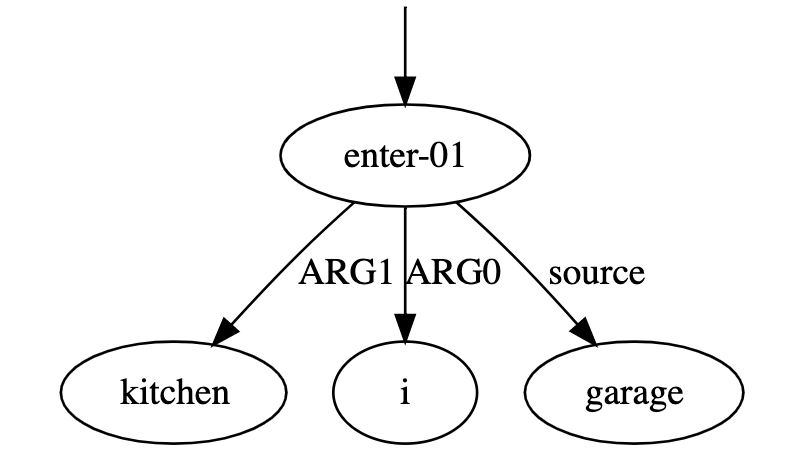

Let's ask ULKB about the logical statements associated with the roleset 'enter.01'. Those logical statements are in Verbnet. We will do this in stages in order to understand how the underlying ULKB model is designed. 

First, we will use a simple API (in ulkb_access_V6) to obtain the logic predicates associated with 'enter.01' 

!pip install SPARQLWrapper

In [4]:
import json
from ulkb_access_V6 import *
output = ulkb_pb_vn_map_parameters("enter.01")
print(json.dumps(output, indent=4, sort_keys=True))

{
    "enter.01": {
        "escape-51.1-2": {
            "ARG0": "ThemRole(Theme)",
            "ARG1": "ThemRole(Destination)"
        }
    },
    "info": "semantic roles for enter.01",
    "provenance": "Unified Mapping"
}


Next, we can obtain the logic predicates associated to 'escape-51.1-2'. We have two predicates that match the roles of Theme (agent) and destination). 

The first predicate is Motion(During(E), Theme) and the second is Path(Theme, Destination, During(E), Initial_location, trajectory). Note that the types are also include Event(during(E)) means that during(E) is an Event. 

In [6]:
output = ulkb_sem_predicates_short("escape-51.1-2")
print(json.dumps(output, indent=4, sort_keys=True))

[
    {
        "example": "He entered the room.",
        "predicates": [
            {
                "label_predicate": "motion",
                "params": [
                    "Event(during(E))",
                    "ThemRole(Theme)"
                ]
            },
            {
                "label_predicate": "path",
                "params": [
                    "ThemRole(Theme)",
                    "ThemRole(Destination)",
                    "Event(during(E))",
                    "ThemRole(Initial_Location)",
                    "ThemRole(Trajectory)"
                ]
            }
        ],
        "roleList": [
            "Theme",
            " Initial_Location",
            " Trajectory",
            " Destination"
        ]
    }
]


### Use case: looking for lexical entries associated to a lemma. Querying the graph directly

In order to understand the underlying graph and model, we'll query the graph programmatically directly. 

All lexical classes from Propbank, Verbnet and Wordnet are abstracted in the class ulkb:Semset (semantic sets). In general, Semsets are lexical units, like the Propbank roleset 'enter.01'. They can be associated to lemmas ('enter' and to parameters, which represent the roles of the verb (agent doing the entering, place entered). Frames describe the different instantiations of the verb (e.g., entering a place, entering a place from another place, entering a place by means of a vehicle, etc.)


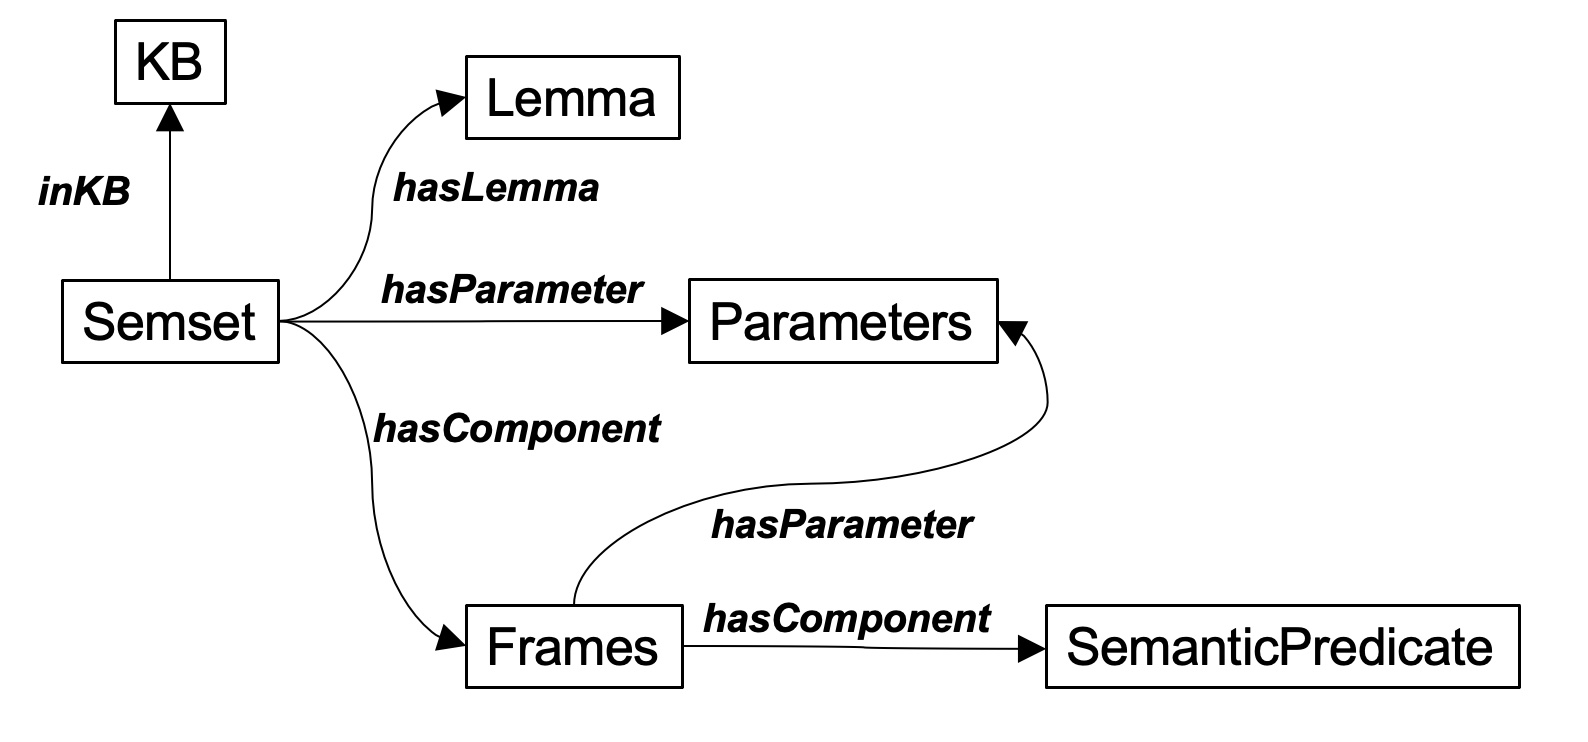



In particular, the model above is instantiated by Propbank roles as follows: 

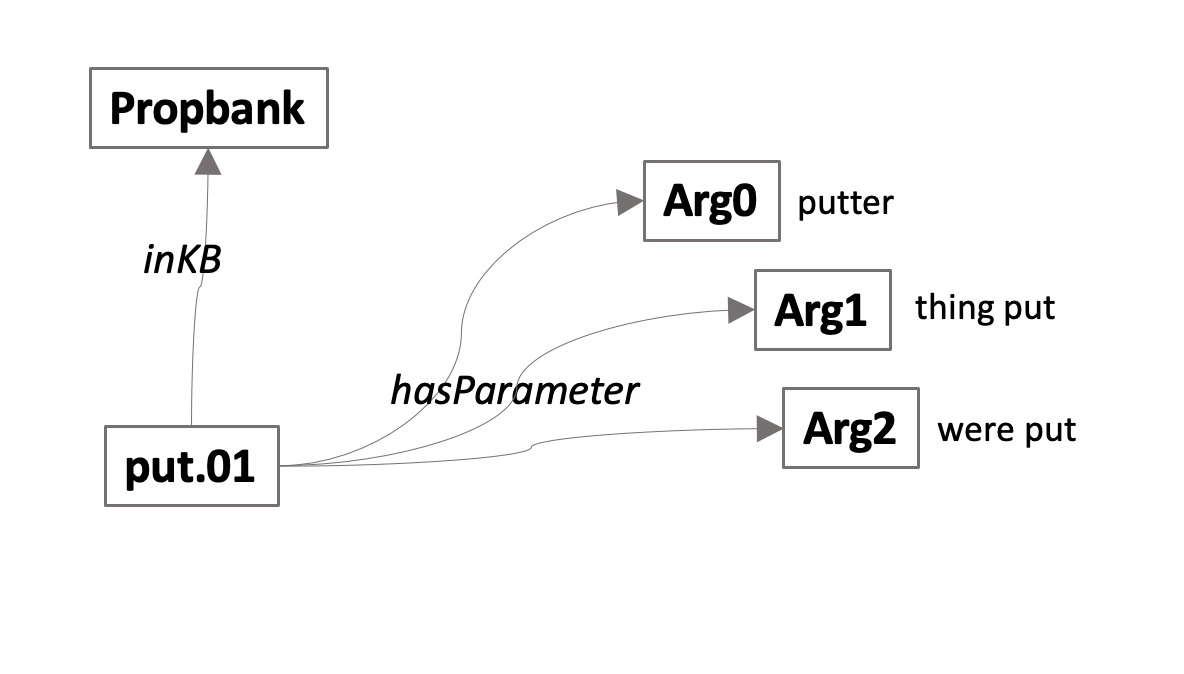



In the case of Verbnet, semsets are more complicated. 

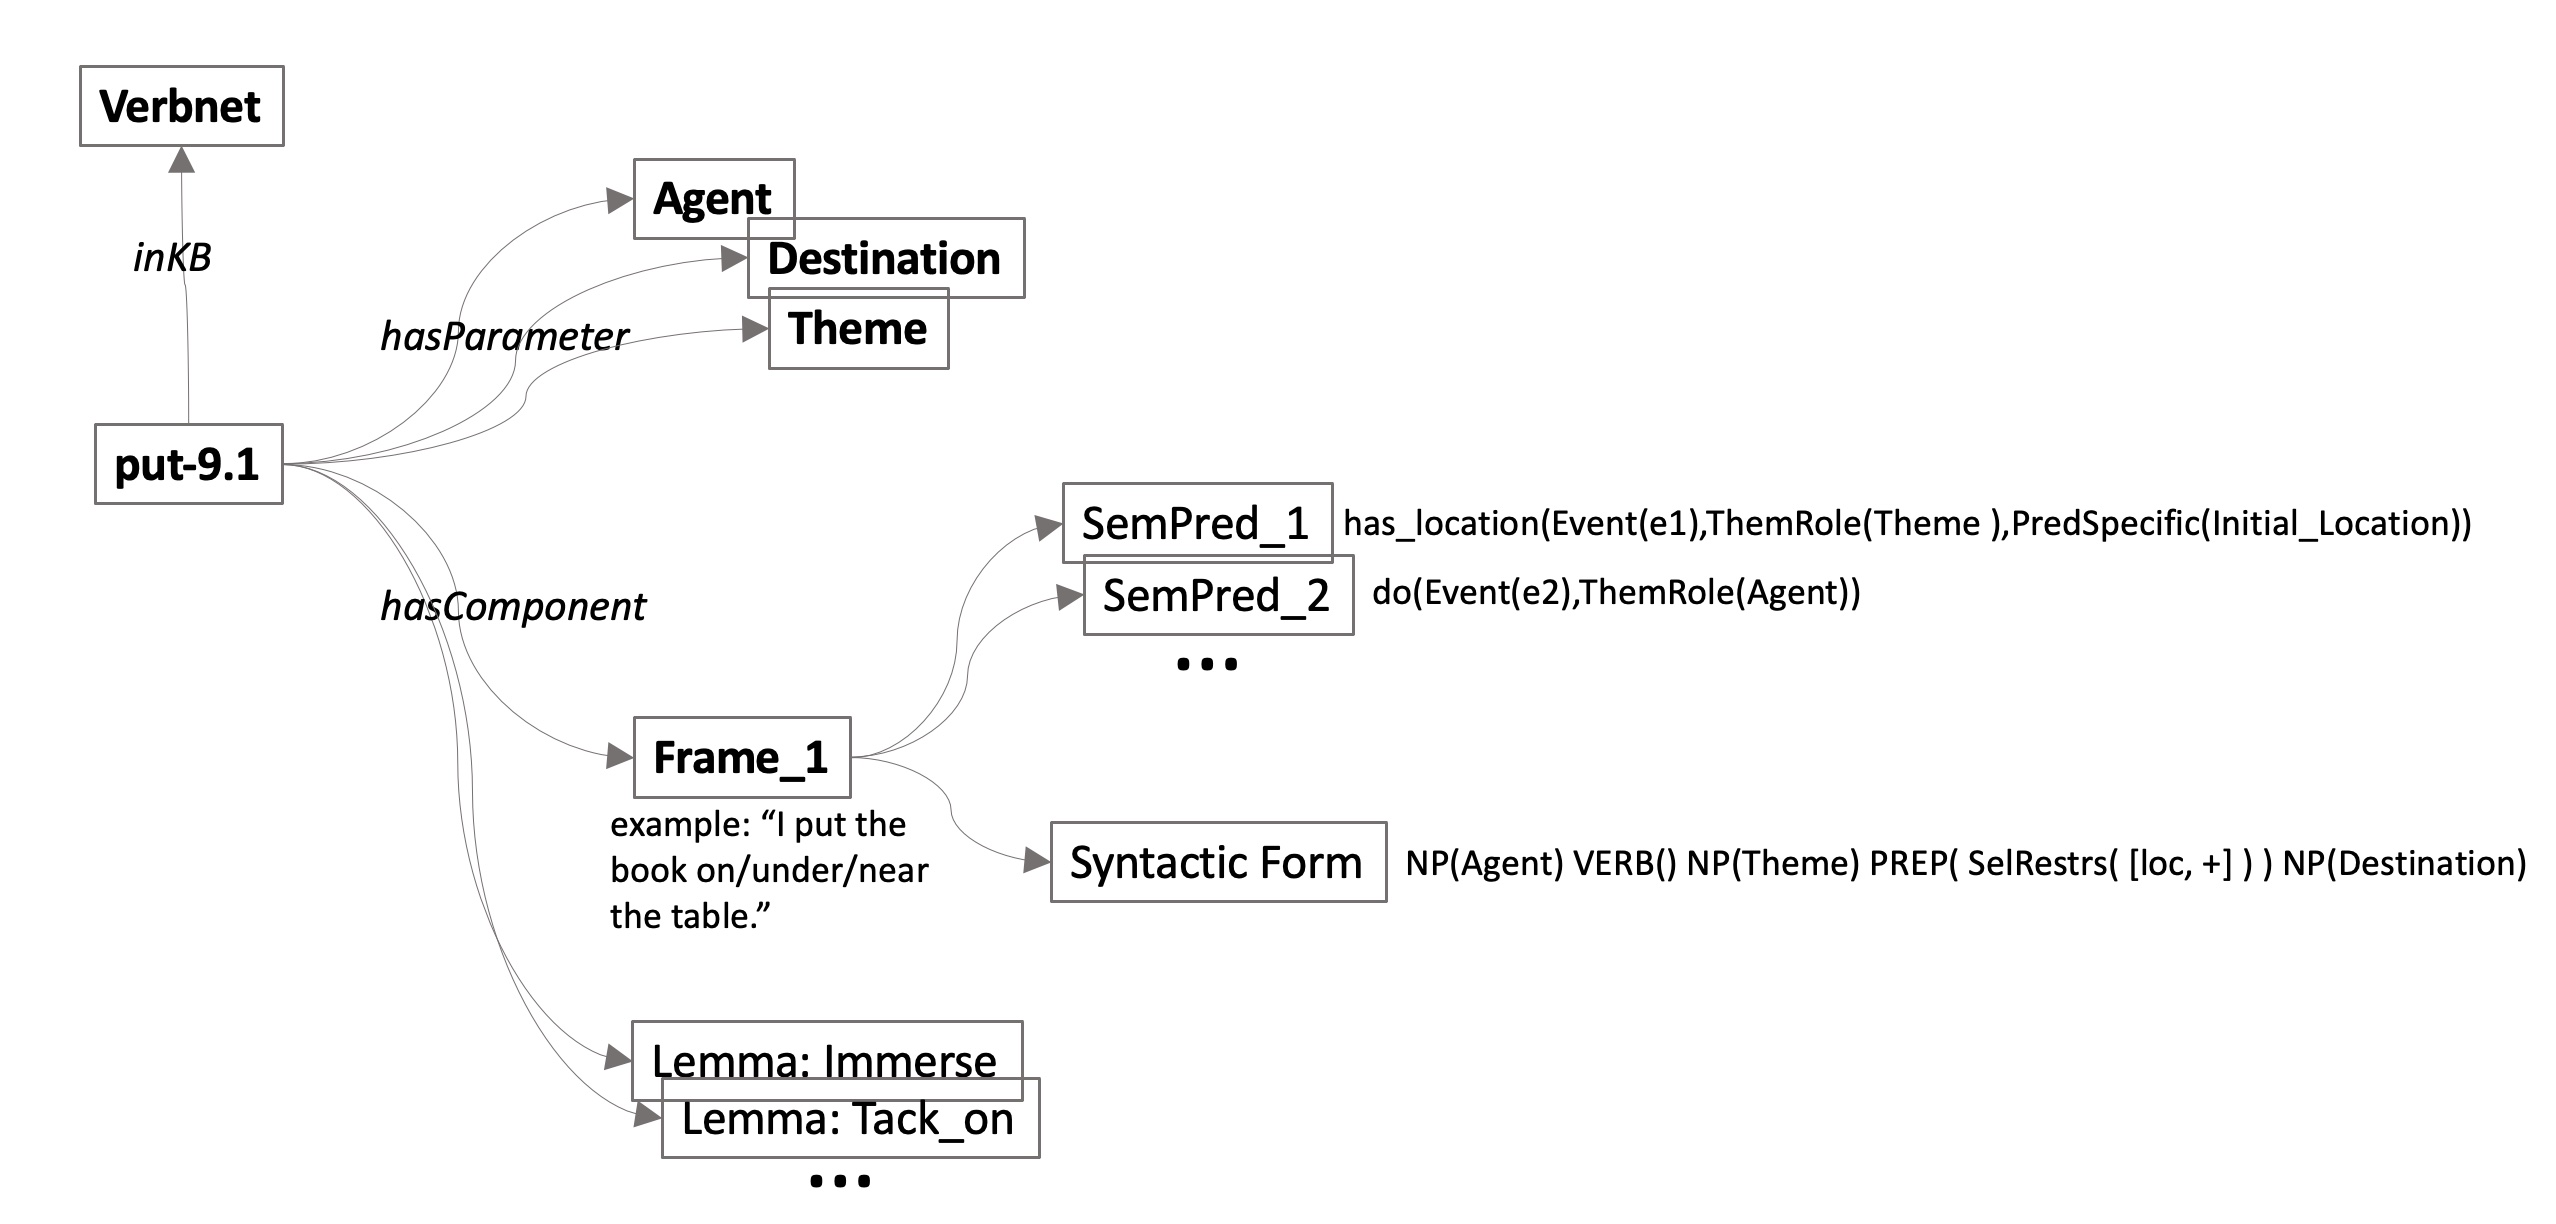



Let's proceed in steps. First, let's look at Semsets associated to a given lemma, say 'enter'. 

In what follows, we explore this model through direct interaction with the graph as installed in a local blazegraph server defined in the sparql variable.  We also define the query prefix with all the namespaces . 

In [19]:
import json
from SPARQLWrapper import SPARQLWrapper, JSON

query_prefix =  ("prefix ulkb: <http://www.ibm.com/ULKB#> \n"                  
                "prefix ulvn: <http://www.ibm.com/UL_VN#> \n"  
                "prefix ulwn: <http://www.ibm.com/UL_WN#> \n"  
                "prefix ulpb: <http://www.ibm.com/UL_PB#> \n")

#We have installed the graph in a local Blazegraph server. But you can install it in any triplestore. 
sparql = SPARQLWrapper("http://127.0.0.1:9999/blazegraph/namespace/ULKB_V6")

In [13]:
# Semsets associated to a lemma (through hasSimilarLemma) in any of the linked kb's
query_text = """SELECT DISTINCT ?semset ?semsetLabel ?kb  WHERE {  
  ?semset rdfs:label ?semsetLabel .   
  ?semset ulkb:hasSimilarLemma ?lemma . 
  ?lemma rdfs:label ?lemmaLabel . 
  FILTER regex(?lemmaLabel, "^enter$", "i") . 
  ?semset ulkb:inKB ?kb . 
 } ORDER BY ?semsetLabel"""

sparql.setQuery(query_prefix + query_text) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:       
       print(result["semset"]["value"] + "\t" + result["semsetLabel"]["value"] + "\t" + result["kb"]["value"])
       

http://www.ibm.com/UL_WN#accede.v.02	accede.v.02	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#embark.v.02	embark.v.02	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#enroll.v.01	enroll.v.01	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_PB#enter_01	enter.01	http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/UL_PB#enter_02	enter.02	http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/UL_WN#enter.v.01	enter.v.01	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#enter.v.02	enter.v.02	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#enter.v.06	enter.v.06	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#figure.v.02	figure.v.02	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#insert.v.01	insert.v.01	http://www.ibm.com/ULKB#WordNet
http://www.ibm.com/UL_WN#record.v.01	record.v.01	http://www.ibm.com/ULKB#WordNet


In [22]:
# Get the parameters for Verbnet Semset associated to enter.01  
query_text = """SELECT DISTINCT ?verb ?pbSemRole ?pbSemRoleDesc ?vnVerbLabel ?vnVarType ?vnVarName WHERE {
  ?verb rdfs:label "enter.01" . 
  ?verb ulkb:hasParameter ?pbParam .
  ?pbParam ulkb:description ?pbSemRoleDesc .  
  ?pbParam rdfs:label ?pbSemRole . 
  OPTIONAL {
  ?vnVerb ulkb:inKB ulkb:VerbNet . 
  ?vnVerb rdfs:label ?vnVerbLabel . 
  ?vnVerb ulkb:hasComponent ?vnFrame . 
  ?vnFrame ulkb:hasComponent ?semPred . 
  ?semPred ulkb:hasParameter ?vnParam . 
  ?pbParam ulkb:mapsTo ?vnParam . 
  ?vnParam ulkb:varType ?vnVarType . 
  ?vnParam ulkb:varName ?vnVarName . 
  }
  }"""

sparql.setQuery(query_prefix + query_text) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:       
       print(result["verb"]["value"] + "\t" + result["vnVerbLabel"]["value"] + "\t" + result["vnVarType"]["value"] + "\t"+ result["vnVarName"]["value"])
       

http://www.ibm.com/UL_PB#enter_01	escape-51.1-2	ThemRole	Theme
http://www.ibm.com/UL_PB#enter_01	escape-51.1-2	ThemRole	Destination


### Other information: Version of a verb

In [24]:
query_text = """SELECT DISTINCT ?provenance WHERE {
                  ?entity rdfs:label "enter.01" .  # FOR the specific verb
                  ?entity ulkb:provenance ?provenance .                 
                }
                  """
        
sparql.setQuery(query_prefix + query_text) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:       
       print(result["provenance"]["value"])
       

Propbank NLTK


### Other information:  Rich vocabulary through maps, track provenance
UL_KB has maps that cluster similar verbs from propbank and verbnet. 

In [26]:
query_text = """SELECT DISTINCT  ?mapping ?entityLabel ?provenance ?KB  WHERE {
                  ?mapping rdfs:label "put" .  # FOR VERB 'PUT'
                  ?entity ulkb:hasMapping ?mapping .                                
                  ?entity rdfs:label ?entityLabel. 
                  ?entity ulkb:provenance ?provenance . 
                  ?entity ulkb:inKB ?KB .  
                } ORDER BY ?entityLabel
                  """
        
sparql.setQuery(query_prefix + query_text) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:       
       row = [result["mapping"]["value"] , result["entityLabel"]["value"] , result["provenance"]["value"], 
                  result["KB"]["value"]]
       print("{: >20} {: >20} {: >20} {: >20}".format(*row)) 
       

http://www.ibm.com/ULKB#put_map           arrange.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map              bury.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map           deposit.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map             embed.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map           emplace.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map           immerse.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map           implant.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map             input.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map            insert.01        Propbank NLTK http://www.ibm.com/ULKB#PropBank
http://www.ibm.com/ULKB#put_map      

### Get other information: All the Semsets associated to a map

In [27]:
query_text = """SELECT DISTINCT  ?otherEntityLabel ?provenance ?KB  WHERE {
                  ?entity rdfs:label "enter.01" . 
                  ?entity ulkb:hasMapping ?mapping . 
                  ?otherEntity ulkb:hasMapping ?mapping .
                  ?otherEntity ulkb:provenance ?provenance . 
                  ?otherEntity ulkb:inKB ?KB .               
                  ?otherEntity rdfs:label ?otherEntityLabel. 
                } ORDER BY ?otherEntity
                  """
        
sparql.setQuery(query_prefix + query_text) 
sparql.setReturnFormat(JSON)
results = sparql.query().convert()


for result in results["results"]["bindings"]:
       sense = result["otherEntityLabel"]["value"] 
       provenance = result["provenance"]["value"]
       KB = result["KB"]["value"]
       print(sense + "\t" + provenance + "\t\t" + KB.split("#")[1])

advance.01	Propbank NLTK		PropBank
approach.01	Propbank NLTK		PropBank
arrive.01	Propbank NLTK		PropBank
ascend.01	Propbank NLTK		PropBank
bolt.01	Propbank NLTK		PropBank
climb.01	Propbank NLTK		PropBank
come.01	Propbank NLTK		PropBank
cross.02	Propbank NLTK		PropBank
decamp.01	Propbank NLTK		PropBank
depart.01	Propbank NLTK		PropBank
descend.01	Propbank NLTK		PropBank
disembark.01	Propbank NLTK		PropBank
emerge.01	Propbank NLTK		PropBank
enter.01	Propbank NLTK		PropBank
escape.01	Propbank NLTK		PropBank
exit.01	Propbank NLTK		PropBank
fall.01	Propbank NLTK		PropBank
file.03	Propbank NLTK		PropBank
flee.01	Propbank NLTK		PropBank
flee.05	Propbank NLTK		PropBank
go.01	Propbank NLTK		PropBank
go.02	Propbank NLTK		PropBank
leave.01	Propbank NLTK		PropBank
leave.11	Propbank NLTK		PropBank
plunge.02	Propbank NLTK		PropBank
recede.01	Propbank NLTK		PropBank
retreat.01	Propbank NLTK		PropBank
return.01	Propbank NLTK		PropBank
rise.01	Propbank NLTK		PropBank
set.04	Propbank NLTK		PropBank
set.